In [48]:
#General
import os
import cv2
import numpy as np
import copy
import torch
import pprint
import random

# custom code
from detectron2.utils.visualizer import Visualizer, GenericMask
from zebrafish.configs import get_default_instance_segmentation_config, load_config, get_rs_101_instance_segmentation_config, update_output_dir_path
from zebrafish.dataset import register_datasets, load_all_image_in_dataset
from zebrafish.evaluation import coco_evaluation, coco_evaluation_all_model
from zebrafish.model import predict
from zebrafish.trainers import TrainingUtil
from zebrafish.visualization import plot_prediction, plot_train_vs_validation_loss, plot_segementation, plot_segementation_vs_real
from zebrafish.utils import is_in_main_dir
from zebrafish.trainers.LossEvalHook import LossEvalHook

#detectron
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper, detection_utils as utils, transforms as T
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(depth=6)
setup_logger()

if "notebooks" in os.getcwd() and "colab" in os.getcwd():
    os.chdir("..")
    os.chdir("..")

assert is_in_main_dir(), "The notebook expectes you to be in the main directory"

register_datasets("dataset")

In [11]:
def data_mapper(dataset_dict):
    # Store orignal height and with such that you can maintain the original aspect ratio
    original_height = dataset_dict["height"]
    original_width = dataset_dict["width"]

    dataset_dict = copy.deepcopy(dataset_dict)

    # Determine which transformations to applyTOR)
    angle = dataset_dict["rotate"]
    is_flipped = dataset_dict["flip"]

    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    # Apply transformations to image
    transformations = []
    
    if angle > 0:
        transformations.append(T.RotationTransform(original_height, original_width, angle=angle))

    if is_flipped:
        transformations.append(T.RandomFlip(prob=is_flipped))

    image, transforms = T.apply_transform_gens(transformations, image) 

    # Store appropriate data
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
    dataset_dict["height"] = original_width
    dataset_dict["width"] = original_width
    dataset_dict["flipped"] = is_flipped
    dataset_dict["rotated"] = angle

    # Apply transformations to annotations
    annos = []
    for obj in dataset_dict.pop("annotations"):
        if obj.get("iscrowd", 0) == 0:
            annos.append(utils.transform_instance_annotations(obj, transforms, image.shape[:2]))

    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

array([array([1218.5, 1695.5, 1187.5, 1800.5, 1151.5, 1909.5, 1122.5, 1984.5,
       1076.5, 2073.5, 1036.5, 2124.5,  995.5, 2148.5,  975.5, 2160.5,
        963.5, 2143.5,  970.5, 2089.5,  989.5, 2063.5, 1011.5, 2030.5,
       1026.5, 1989.5, 1050.5, 1953.5, 1067.5, 1906.5, 1096.5, 1834.5,
       1122.5, 1750.5, 1144.5, 1697.5, 1153.5, 1654.5, 1199.5, 1636.5,
       1231.5, 1636.5, 1228.5, 1697.5])], dtype=object)

In [60]:
np.asarray(gt["instances"].gt_masks)

array([[array([1218.5, 1695.5, 1187.5, 1800.5, 1151.5, 1909.5, 1122.5, 1984.5,
       1076.5, 2073.5, 1036.5, 2124.5,  995.5, 2148.5,  975.5, 2160.5,
        963.5, 2143.5,  970.5, 2089.5,  989.5, 2063.5, 1011.5, 2030.5,
       1026.5, 1989.5, 1050.5, 1953.5, 1067.5, 1906.5, 1096.5, 1834.5,
       1122.5, 1750.5, 1144.5, 1697.5, 1153.5, 1654.5, 1199.5, 1636.5,
       1231.5, 1636.5, 1228.5, 1697.5])],
       [array([1001.5, 1704.5,  954.5, 1724.5,  910.5, 1731.5,  866.5, 1754.5,
        830.5, 1772.5,  826.5, 1764.5,  799.5, 1781.5,  770.5, 1793.5,
        746.5, 1772.5,  751.5, 1733.5,  866.5, 1637.5,  960.5, 1622.5,
       1079.5, 1610.5, 1204.5, 1589.5, 1260.5, 1583.5, 1301.5, 1588.5,
       1324.5, 1601.5, 1308.5, 1636.5, 1231.5, 1639.5, 1195.5, 1636.5,
       1154.5, 1656.5, 1054.5, 1682.5,  995.5, 1701.5])],
       [array([1216.5, 1550.5, 1161.5, 1501.5, 1101.5, 1466.5, 1040.5, 1430.5,
        944.5, 1342.5,  958.5, 1314.5, 1013.5, 1336.5, 1098.5, 1378.5,
       1180.5, 1422.5, 1

In [53]:
masks = np.asarray(gt["instances"].gt_masks)
masks = [GenericMask(x, gt["height"], gt["width"]) for x in masks]

IndexError: tuple index out of range

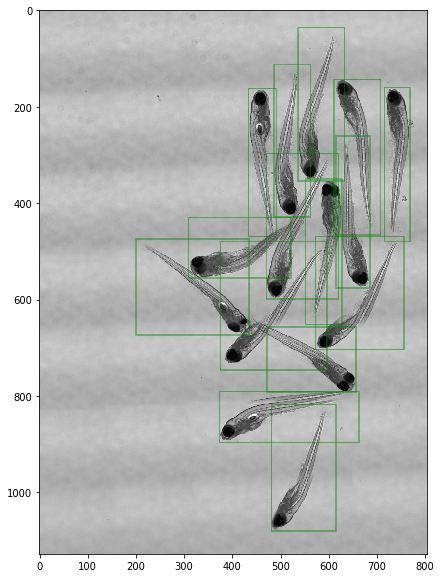

In [44]:
gt = data_mapper(d)
img = gt["image"].cpu().numpy()
img = np.moveaxis(img, 0, -1)

visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
for box in gt['instances'].gt_boxes.tensor.cpu().numpy():
    visualizer.draw_box(box)
    
visualizer

vis = visualizer.output
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

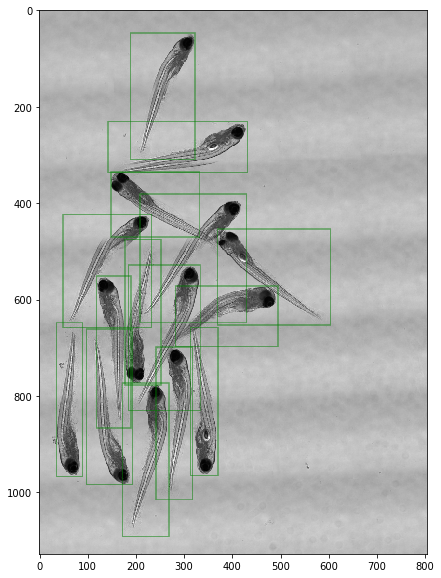

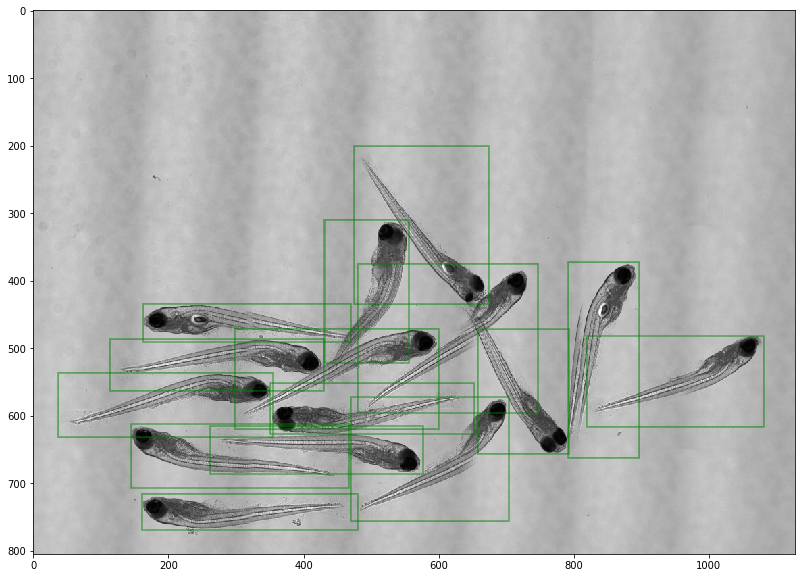

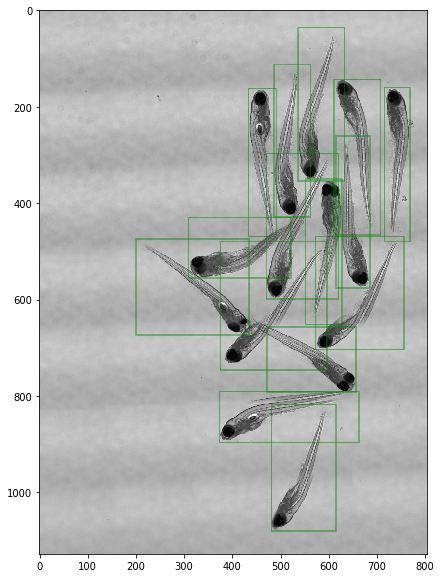

In [42]:
dataset_name = "train_UNLABELED_TYPE_Flip_Rotate"
dataset_dicts = DatasetCatalog.get(dataset_name)
metadata = MetadataCatalog.get(dataset_name)

dataset_dicts = list(filter(lambda x: "dataset/training disordered_Snapshot_20190312_2884.jpg" == x["file_name"] , dataset_dicts))

for d in random.sample(dataset_dicts, 3):
    gt = data_mapper(d)
    img = gt["image"].cpu().numpy()
    img = np.moveaxis(img, 0, -1)
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    for box in gt['instances'].gt_boxes.tensor.cpu().numpy():
        visualizer.draw_box(box)
        
    vis = visualizer.output
    plt.figure(figsize=(14, 10))
    plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    
    